In [1]:
# Face Swap with Delaunay Triangles for Multiple Destination Images #

In [2]:
# Importing Libraries

import os
import cv2
import dlib
import glob
import random
import numpy as np
import shutil as sh
import matplotlib.pyplot as plt
from PIL import Image, ImageStat

In [3]:
# Getting the Source File

source = "./source.jpg"
print("Source Image:", source)

Source Image: ./source.jpg


In [4]:
# Getting the Destination Files and Making Directory for the Result Files

DESTINATION_PATH = "./destination"
DESTINATION_PATH = DESTINATION_PATH.replace("\\", "/")

if (DESTINATION_PATH[-1] == "/"):
    DESTINATION_PATH = DESTINATION_PATH[:-1]

destination_files = glob.glob(DESTINATION_PATH + '/*.*')

RESULT_PATH = DESTINATION_PATH.split(DESTINATION_PATH.split("/")[-1])[0] + DESTINATION_PATH.split("/")[-1] + "_"

if os.path.exists(RESULT_PATH):
    sh.rmtree(RESULT_PATH)
os.mkdir(RESULT_PATH)

print("Folder of destination images:", DESTINATION_PATH)
print("New files will be saved here:", RESULT_PATH)

Folder of destination images: ./destination
New files will be saved here: ./destination_


Source Image: ./source.jpg


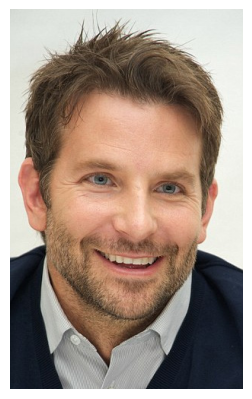

In [5]:
# Plotting the Source Image

print(f"Source Image: {source}")
source_image = cv2.imread(source, 1)
i = source_image.shape[1] / source_image.shape[0]
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB));

In [6]:
# Loading the Source Image

face = cv2.imread(source, 1)

In [7]:
# Loading Models and Predictors From the 'dlib' Library to Detect Landmarks on Both Faces

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./src/shape_predictor_68_face_landmarks.dat")

source_faces = len(detector(face, 1))

print(f"Number of Faces in the Source Image: {source_faces}")

Number of Faces in the Source Image: 1


In [8]:
# Detecting Face Regions by Using Shape Predictor

def face_detector(img):
    # loading the Face Detector and the Shape Predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("./src/shape_predictor_68_face_landmarks.dat")

    # Reading the Input Image and Converting It to Grayscale
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detecting the Face Regions
    rects = detector(gray, 1)

    # Defining A List of Polylines
    polylines_all = []

    # Going Through All the Face Bounding Boxes
    for rect in rects:

        # Getting A Fresh Copy of the Original Image for Each Face ROI
        image_cp = image.copy()

        # Applying the Shape Predictor to Each Face ROI
        landmarks = predictor(gray, rect)
        # Defining A List for the 68 Landmark Points
        landmarks_points = []

        def get_landmarks(landmarks, landmarks_points):
            for n in range(68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                landmarks_points.append((x, y))

        # Landmarks are Stored in "landmarks_points"
        get_landmarks(landmarks, landmarks_points)

        # Drawing A Convex Hull over the Detected 68 Landmarks of the Current Face
        points = np.array(landmarks_points, np.int32)
        convexhull = cv2.convexHull(points)

        # Adding the Current Convex Hull on the Source Image
        polylines_all.append(cv2.polylines(image_cp, [convexhull], True, (255, 255, 255), 2))

    # Returning the List of Convex Hulls on Each Individual Face
    return polylines_all

Choose the Source Face to Place over the Destination Faces:
Face Index: 0

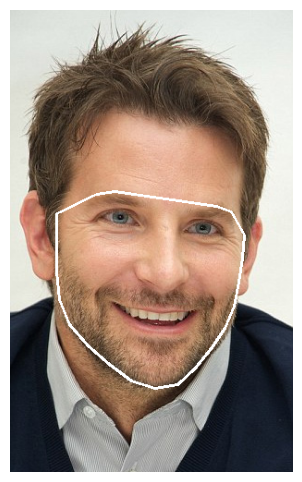

In [9]:
# Plotting the List of Images with Different Convex Hulls on Each Individual Face

# Getting the Height Value of the Source Image for the Thickness of Borderline 
img = cv2.imread(source)
h_src = img.shape[0]
w_src = img.shape[1]
border = np.zeros((h_src, int(h_src / 100), 3), dtype=np.uint8)

print("Choose the Source Face to Place over the Destination Faces:")
print("Face Index: ", end="")

detected_faces = face_detector(source)

first = True
facenum = 0
for source_face in detected_faces:
    if first:
        print(f"{facenum}", end="")
        all_faces = source_face
        facenum += 1
        first = False
    else:
        print(f", {facenum}", end="")
        all_faces = cv2.hconcat([all_faces, border, source_face])
        facenum += 1

i = len(detected_faces)
plt.figure(figsize=(int(6 * i), 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(all_faces, cv2.COLOR_BGR2RGB));

In [10]:
###########################
###########################

facenum = 0

###########################
###########################

In [11]:
# Detecting If Any of the Processed Images is Gray / Black & White

def detect_grayscale(file, thumb_size=50, mse_limit=30, adjust_color_bias=True):
    opencv_image = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    img = Image.fromarray(opencv_image)
    # pil_img = Image.open(file)

    bands = img.getbands()
    if bands == ('R', 'G', 'B') or bands == ('R', 'G', 'B', 'A'):
        thumb = img.resize((thumb_size, thumb_size))
        sse, bias = 0, [0, 0, 0]

        if adjust_color_bias:
            bias = ImageStat.Stat(thumb).mean[:3]
            bias = [b - sum(bias) / 3 for b in bias]

        for pixel in thumb.getdata():
            mu = sum(pixel) / 3
            sse += sum((pixel[i] - mu - bias[i]) * (pixel[i] - mu - bias[i]) for i in [0, 1, 2])

        mse = float(sse) / (thumb_size * thumb_size)

        if mse <= mse_limit:   # If Not Colored
            return True

        else:                  # If Colored
            return False

    else:                      # If Not Colored
        return True

In [12]:
# Loading Models and Predictors of the 'dlib' library to Detect Landmarks on the Processed Faces

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./src/shape_predictor_68_face_landmarks.dat")

for destination in destination_files:

    destination = destination.replace("\\", "/")
    face = cv2.imread(source, 1)
    body = cv2.imread(destination, 1)

    ####################################################

    # If the Source is Colored and the Destination is Gray, the Source is Converted to Grayscale
    # If the Source is Gray and the Destination is Colored, the Source is Colorized
    # As a Result, the Final Image will Have Consistent Color Distributions

    if detect_grayscale(destination) and not detect_grayscale(source):

        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = cv2.cvtColor(face, cv2.COLOR_GRAY2BGR)
        print("The source image is converted to grayscale.")

    elif detect_grayscale(source) and not detect_grayscale(destination):
        
        from cv2 import dnn

        # Assigning Model File Paths
        prototxt = './src/colorization_deploy_v2.prototxt'
        caffemodel = './src/colorization_release_v2.caffemodel'
        hull = './src/pts_in_hull.npy'

        # Loading Model & Proto Files and Hull Points from Disk
        net = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)
        pts = np.load(hull)

        # Adding the Cluster Centers as 1x1 Convolutions to the Model
        layer_class8 = net.getLayerId("class8_ab")
        layer_conv8 = net.getLayerId("conv8_313_rh")
        pts = pts.transpose().reshape(2, 313, 1, 1)
        net.getLayer(layer_class8).blobs = [pts.astype("float32")]
        net.getLayer(layer_conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

        # Loading the Input Image
        #image = cv2.imread(source, 1)
        image = face

        # Converting Image from BGR to RGB
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalizing the Image by Changing Pixel Values to the Range of [0, 1]
        normalized = image.astype("float32") / 255.0
        # Converting the Normalized Image from BGR to LAB Color Space
        #lab_image = cv2.cvtColor(normalized, cv2.COLOR_RGB2LAB)
        lab_image = cv2.cvtColor(normalized, cv2.COLOR_BGR2LAB)

        # Resizing the Lab Image to 224 x 224
        resized_lab_image = cv2.resize(lab_image, (224, 224))
        # Splitting Channels and Extracting the 'L' Channel
        L = cv2.split(resized_lab_image)[0]
        # Mean Centering
        L -= 50

        # Sending 'L' Channel to the Network to Predict 'a' and 'b' Channel Values
        net.setInput(cv2.dnn.blobFromImage(L))
        # Finding the Values of 'a' and 'b' Channels
        ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
        # Resizing the Predicted 'ab' Volume to the Input Image Size
        ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

        # Grabbing the 'L' Channel from the Original Input Image
        L = cv2.split(lab_image)[0]
        # Concatenating the Original 'L' Channel with the Predicted 'ab' Channels
        lab_colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

        # Converting the Output Image from the LAB Color Space to RGB
        #rgb_colorized = cv2.cvtColor(lab_colorized, cv2.COLOR_LAB2RGB)
        bgr_colorized = cv2.cvtColor(lab_colorized, cv2.COLOR_LAB2BGR)
        # Clipping Any Values that Fall Outside the Range of [0, 1]
        bgr_colorized = np.clip(bgr_colorized, 0, 1)

        # Converting the Colorized Image from "Float" in [0, 1] to Unsigned 8-bit "Int" in: [0, 255]
        bgr_colorized = (255 * bgr_colorized).astype("uint8")

        face = bgr_colorized
        print("The source image is colorized.")
        
    ####################################################

    # Converting Images to Grayscale:
    face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    body_gray = cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)

    ####################################################

    def get_landmarks(landmarks, landmarks_points):
        for n in range(68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_points.append((x, y))


    def get_index(arr):
        index = None
        for num in arr[0]:
            index = num
            break
        return index

    ####################################################

    # Detecting All the Faces in the Source Image
    rects1 = detector(face_gray, 1)

    if len(rects1) == 0:
        print("The Source Image does not Have Any Face!")
        # exit()
        break
    else:
        rect1 = rects1[facenum]  # Getting the First Face in the Source Image

        # Getting 68 Landmark Points for the Source Face and Finding Its (x, y) Coordinates
        landmarks = predictor(face_gray, rect1)
        landmarks_points = []
        get_landmarks(landmarks, landmarks_points)

        # Drawing a Contour Shape Around the Face by Using the convexhull Module of the OpenCV Library
        points = np.array(landmarks_points, np.int32)
        convexhull = cv2.convexHull(points)

    ####################################################

    # Detecting All the Faces in the Destination Images
    rects2 = detector(body_gray, 1)

    if len(rects2) == 0:
        continue  # Pass to the Next Destination Image
    else:
        # print(len(rects2), "faces detected.")
        convexhull2_all = []
        landmarks2_points_all = []

        for rect2 in rects2:  # For Each Face in the Current Destination Image
            # Getting 68 Landmark Points for the Current Face of the Current Destination Image
            landmarks2 = predictor(body_gray, rect2)
            landmarks2_points = []
            get_landmarks(landmarks2, landmarks2_points)
            landmarks2_points_all.append(landmarks2_points)

            # Generating A Convex Hull for the Current Face in the Current Destination Image
            points2 = np.array(landmarks2_points, np.int32)
            convexhull2 = cv2.convexHull(points2)
            convexhull2_all.append(convexhull2)

    ####################################################

    # Detecting Triangles in the Contour Areas
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    face_cp = face.copy()

    for triangle in triangles:

        # Getting the Vertex of the Triangle
        pt1 = (triangle[0], triangle[1])
        pt2 = (triangle[2], triangle[3])
        pt3 = (triangle[4], triangle[5])

        # Drawing A Line for Each Side of the Triangle
        cv2.line(face_cp, pt1, pt2, (255, 255, 255), 1, 0)
        cv2.line(face_cp, pt2, pt3, (255, 255, 255), 1, 0)
        cv2.line(face_cp, pt3, pt1, (255, 255, 255), 1, 0)

        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = get_index(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = get_index(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = get_index(index_pt3)

        # Saving Coordinates If the Triangle Exists and Has 3 Vertices
        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            vertices = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(vertices)

    ####################################################

    body_new_face_all = []

    for landmarks2_points in landmarks2_points_all:

        # Creating Empty Matrices in the Shapes of Images
        height, width, channels = body.shape  # h x w x c is Obtained from the Destination Image
        body_new_face = np.zeros((height, width, channels), np.uint8)
        height, width = face_gray.shape  # h x w is Obtained from the Grayscale ver. of the Source
        mask = np.zeros((height, width), np.uint8)  # Mask is Formed from the Grayscale Version of the Source

        face_ok = True
        for triangle in indexes_triangles:

            # Coordinates of the Source Face's Delaunay Triangles
            pt1 = landmarks_points[triangle[0]]
            pt2 = landmarks_points[triangle[1]]
            pt3 = landmarks_points[triangle[2]]
            triangle1 = np.array([pt1, pt2, pt3], np.int32)

            # Getting the Delaunay Triangles
            (x, y, widht, height) = cv2.boundingRect(triangle1)
            cropped_triangle = face[y: y + height, x: x + widht]
            cropped_mask = np.zeros((height, widht), np.uint8)

            # Filling Triangles to Generate the Mask
            points = np.array([[pt1[0] - x, pt1[1] - y],
                               [pt2[0] - x, pt2[1] - y],
                               [pt3[0] - x, pt3[1] - y]], np.int32)
            cv2.fillConvexPoly(cropped_mask, points, 255)

            # Coordinates of the Destination Face's Delaunay Triangles
            pt1 = landmarks2_points[triangle[0]]
            pt2 = landmarks2_points[triangle[1]]
            pt3 = landmarks2_points[triangle[2]]
            triangle2 = np.array([pt1, pt2, pt3], np.int32)

            # Getting the Delaunay Triangles
            (x, y, widht, height) = cv2.boundingRect(triangle2)
            cropped_mask2 = np.zeros((height, widht), np.uint8)

            # Filling Triangles to Generate the Mask
            points2 = np.array([[pt1[0] - x, pt1[1] - y],
                                [pt2[0] - x, pt2[1] - y],
                                [pt3[0] - x, pt3[1] - y]], np.int32)
            cv2.fillConvexPoly(cropped_mask2, points2, 255)

            # Deforming the Triangles to Fit the Subject's Face
            points = np.float32(points)
            points2 = np.float32(points2)
            M = cv2.getAffineTransform(points, points2)  # Warping the 1st triangle's content to fit in the 2nd one's:
            dist_triangle = cv2.warpAffine(cropped_triangle, M, (widht, height))
            dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=cropped_mask2)

            # If the Swapping Process for This Current Face Fails, Continue with the Next Face
            try:
                # Joining All the Distorted Triangles to Make the Mask Fit in the Destination Face
                body_new_face_rect_area = body_new_face[y: y + height, x: x + widht]
                body_new_face_rect_area_gray = cv2.cvtColor(body_new_face_rect_area, cv2.COLOR_BGR2GRAY)

                # Creating A Face Mask
                masked_triangle = cv2.threshold(body_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
                dist_triangle = cv2.bitwise_and(dist_triangle, dist_triangle, mask=masked_triangle[1])

                # Adding the Pieces to the Face Mask
                body_new_face_rect_area = cv2.add(body_new_face_rect_area, dist_triangle)
                body_new_face[y: y + height, x: x + widht] = body_new_face_rect_area
            except:
                continue

        body_new_face_all.append(body_new_face)

    ####################################################

    switch = True
    added_faces = 0

    for body_new_face, convexhull2 in zip(body_new_face_all, convexhull2_all):
        body_face_mask = np.zeros_like(body_gray)
        body_head_mask = cv2.fillConvexPoly(body_face_mask, convexhull2, 255)
        body_face_mask = cv2.bitwise_not(body_head_mask)

        (x, y, widht, height) = cv2.boundingRect(convexhull2)
        center_face2 = (int((x + x + widht) / 2), int((y + y + height) / 2))

        body_maskless = cv2.bitwise_and(body, body, mask=body_face_mask)
        result = cv2.add(body_maskless, body_new_face)

        if switch:  # Placing the Source Face on the First Body in the Current Destination Image 
            try:
                seamlessclone = cv2.seamlessClone(result, body, body_head_mask, center_face2, cv2.NORMAL_CLONE)
                added_faces += 1
                switch = False
            except:
                continue

        else:  # Placing the Source Face on the Following Bodies in the Destination Image
            try:
                seamlessclone = cv2.seamlessClone(result, seamlessclone, body_head_mask, center_face2, cv2.NORMAL_CLONE)
                added_faces += 1
            except:
                continue

    ####################################################

    if added_faces != 0:  # If Any Swapping is Implemented, Save the Result Image and Print Its Path  
        print(RESULT_PATH + "/" + destination.split("/")[-1])
        cv2.imwrite(RESULT_PATH + "/" + destination.split("/")[-1], seamlessclone);
    else:  # If No Swapping is Implemented, Skip Processing the Current Destination Image
        print(f"*Couldn't process:" + destination.split("/")[-1])
        continue

./destination_/img_001.jpg
./destination_/img_002.png
The source image is converted to grayscale.
./destination_/img_003.jpg
./destination_/img_004.jpg
./destination_/img_005.jpg
./destination_/img_006.jpg
The source image is converted to grayscale.
./destination_/img_007.jpg
./destination_/img_008.jpg
./destination_/img_009.jpg
./destination_/img_010.jpg
./destination_/img_011.jpg
./destination_/img_012.jpg
./destination_/img_013.jpg
./destination_/img_014.jpg
./destination_/img_015.jpg
./destination_/img_016.jpg
The source image is converted to grayscale.
./destination_/img_017.jpg
./destination_/img_018.jpg
./destination_/img_019.jpg
./destination_/img_020.jpg
./destination_/img_021.jpg
./destination_/img_022.jpg
The source image is converted to grayscale.
./destination_/img_023.jpg
./destination_/img_024.jpg
./destination_/img_025.jpg
./destination_/img_026.jpg
./destination_/img_027.jpg
./destination_/img_028.jpg
./destination_/img_029.jpg
./destination_/img_030.jpg


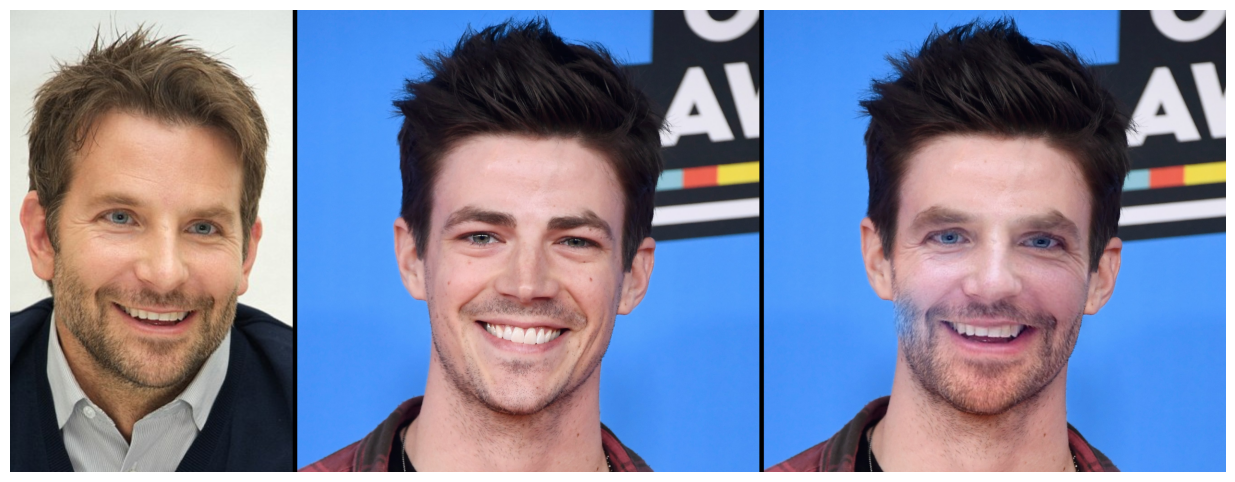

In [13]:
# Demonstrating A Result Image by Comparing It with Both the Source and the Destination Images

test_source = cv2.imread(source, 1)
test_input = cv2.imread(DESTINATION_PATH + "/img_001.jpg", 1)
test_output = cv2.imread(RESULT_PATH + "/img_001.jpg", 1)

h_s = test_source.shape[0]
w_s = test_source.shape[1]
h_n = test_input.shape[0]
w_n = int((h_n * w_s) / h_s)
border = np.zeros((h_n, int(h_n / 100), 3), dtype=np.uint8)

show_results = cv2.hconcat([cv2.resize(test_source, (w_n, h_n)), border, test_input, border, test_output])
i = show_results.shape[1] / show_results.shape[0]
plt.figure(figsize=(6 * i, 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(show_results, cv2.COLOR_BGR2RGB));

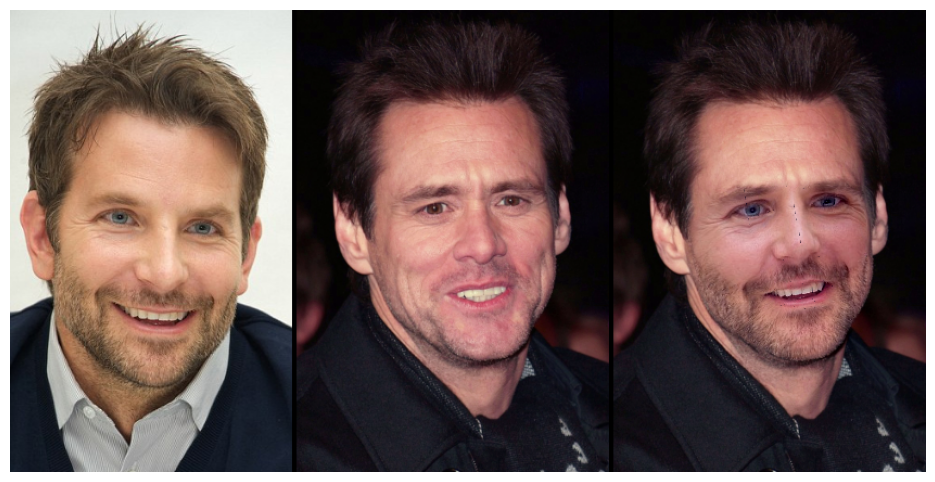

In [14]:
# Demonstrating A Result Image by Comparing It with Both the Source and the Destination Images

test_source = cv2.imread(source, 1)
test_input = cv2.imread(DESTINATION_PATH + "/img_002.png", 1)
test_output = cv2.imread(RESULT_PATH + "/img_002.png", 1)

h_s = test_source.shape[0]
w_s = test_source.shape[1]
h_n = test_input.shape[0]
w_n = int((h_n * w_s) / h_s)
border = np.zeros((h_n, int(h_n / 100), 3), dtype=np.uint8)

show_results = cv2.hconcat([cv2.resize(test_source, (w_n, h_n)), border, test_input, border, test_output])
i = show_results.shape[1] / show_results.shape[0]
plt.figure(figsize=(6 * i, 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(show_results, cv2.COLOR_BGR2RGB));


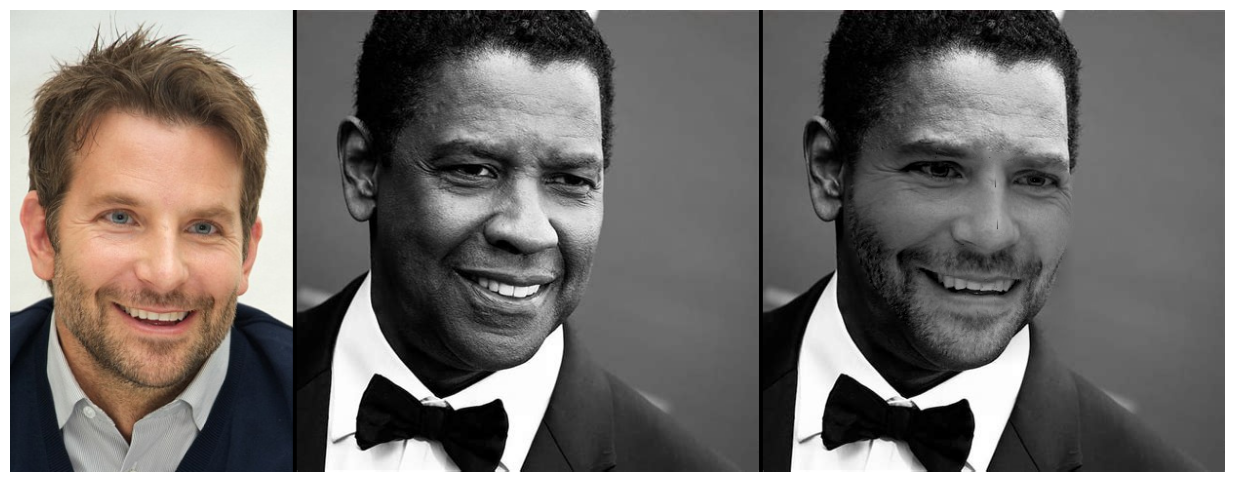

In [15]:
# Demonstrating A Result Image by Comparing It with Both the Source and the Destination Images 

test_source = cv2.imread(source, 1)
test_input = cv2.imread(DESTINATION_PATH + "/img_003.jpg", 1)
test_output = cv2.imread(RESULT_PATH + "/img_003.jpg", 1)

h_s = test_source.shape[0]
w_s = test_source.shape[1]
h_n = test_input.shape[0]
w_n = int((h_n * w_s) / h_s)
border = np.zeros((h_n, int(h_n / 100), 3), dtype=np.uint8)

show_results = cv2.hconcat([cv2.resize(test_source, (w_n, h_n)), border, test_input, border, test_output])
i = show_results.shape[1] / show_results.shape[0]
plt.figure(figsize=(6 * i, 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(show_results, cv2.COLOR_BGR2RGB));

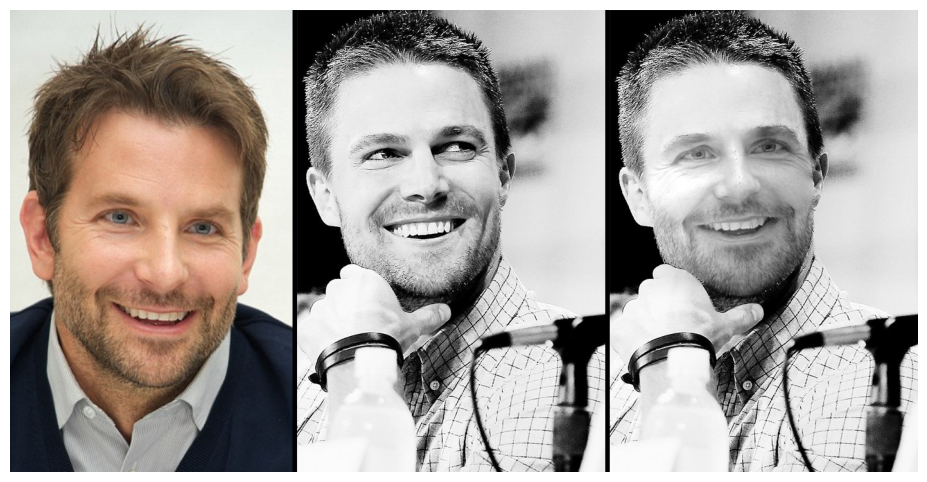

In [16]:
# Demonstrating A Result Image by Comparing It with Both the Source and the Destination Images

test_source = cv2.imread(source, 1)
test_input = cv2.imread(DESTINATION_PATH + "/img_007.jpg", 1)
test_output = cv2.imread(RESULT_PATH + "/img_007.jpg", 1)

h_s = test_source.shape[0]
w_s = test_source.shape[1]
h_n = test_input.shape[0]
w_n = int((h_n * w_s) / h_s)
border = np.zeros((h_n, int(h_n / 100), 3), dtype=np.uint8)

show_results = cv2.hconcat([cv2.resize(test_source, (w_n, h_n)), border, test_input, border, test_output])
i = show_results.shape[1] / show_results.shape[0]
plt.figure(figsize=(6 * i, 6)); plt.axis('off')
plt.imshow(cv2.cvtColor(show_results, cv2.COLOR_BGR2RGB));